# Audrey: Automatic Digit Recognizer

This notebook shows you how to train a convolutional neural network to recognize the digits 0-9.

This project is motivated by the desire to recreate Audery, s widely cited as the first operational speech recognizer.

More information about Audrey can be found in this paper [Vocal Features: From Voice Identification to Speech Recognition by Machine](https://nyuscholars.nyu.edu/ws/portalfiles/portal/576153242/Vocal_Features_From_Voice_Identification.pdf) by Xiaochang Li and Mara Mills.

This project is also a nice exercise into deep learning, as it functions as an audio analog to [MNIST](https://en.wikipedia.org/wiki/MNIST_database).

## Installation

Python==3.10
numpy
librosa

## To-do

- Consolidate using librosa vs torchaudio vs sf file (pick one and go!)
- Consolidate using numpy vs pytorch (maybe just use pytorch)
- Don't pad with zeros but with...something just above zero? Noise?
- Rewrite convnet architecture with notes from ARENA
- Wire in Weights and Biases

In [2]:
# Data augmentation that we will use later in pre-processing our dataset

import numpy as np
import librosa

def noise(data, noise_amt=0.035):
    noise_amp = noise_amt*np.random.uniform()*np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5) * 1000)
    return np.roll(data, shift_range)


def pitch(data, sampling_rate, n_steps=2):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=n_steps)

In [3]:
# take our recorded digits, and augment them to create a larger dataset

import os
import glob
import subprocess
import librosa
import numpy as np
import soundfile as sf
from tqdm.notebook import tqdm

# get all files in jo_digits/unprocessed
files = glob.glob('jo_digits/unprocessed/*')
print(files)

for file in tqdm(files):
    # get the digit from the file name
    digit = file.split('/')[-1].split('_')[1].split('.')[0]
    
    # create the directory if it doesn't exist
    os.makedirs(f'jo_digits/processed/{digit}', exist_ok=True)

    # load file with sf
    audio, sample_rate = sf.read(file)

    for i in tqdm(range(1000)):
        
        processed_audio = noise(audio, np.random.uniform(0.001, 0.01))
        processed_audio = stretch(processed_audio, rate=np.random.uniform(0.8, 1.2))
        processed_audio = shift(processed_audio)
        processed_audio = pitch(processed_audio, sample_rate, n_steps=np.random.randint(-3, 3))

        sf.write(f'jo_digits/processed/{digit}/{digit}_{i}.wav', processed_audio, sample_rate)



['jo_digits/unprocessed/jo_8.wav', 'jo_digits/unprocessed/jo_2.wav', 'jo_digits/unprocessed/jo_6.wav', 'jo_digits/unprocessed/jo_9.wav', 'jo_digits/unprocessed/jo_4.wav', 'jo_digits/unprocessed/jo_5.wav', 'jo_digits/unprocessed/jo_1.wav', 'jo_digits/unprocessed/jo_0.wav', 'jo_digits/unprocessed/jo_3.wav', 'jo_digits/unprocessed/jo_7.wav']


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# get all of the fies in speech_digits with glob
import glob

files = glob.glob('jo_digits/processed/*/*')

print(len(files))
print(files[:5])


10000
['jo_digits/processed/8/8_982.wav', 'jo_digits/processed/8/8_122.wav', 'jo_digits/processed/8/8_515.wav', 'jo_digits/processed/8/8_556.wav', 'jo_digits/processed/8/8_374.wav']


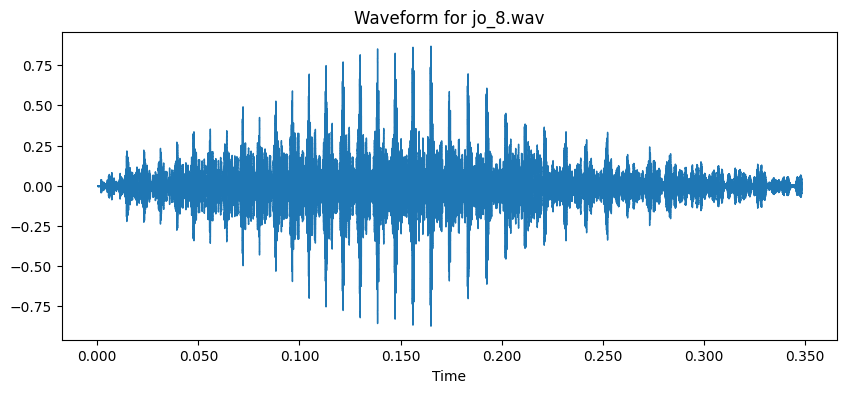

<Figure size 1000x400 with 0 Axes>

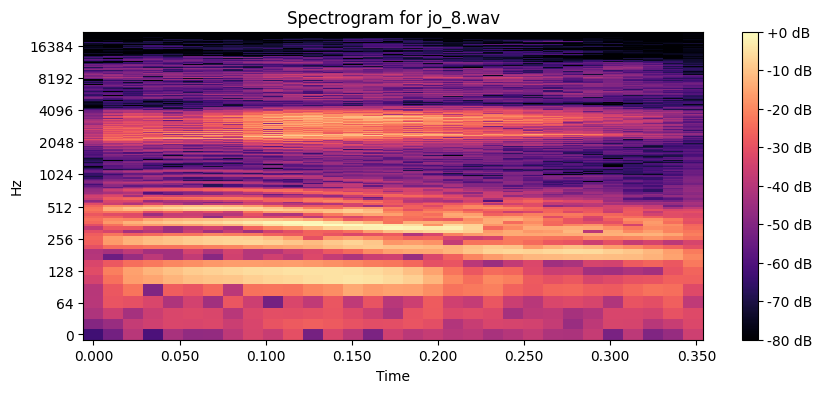

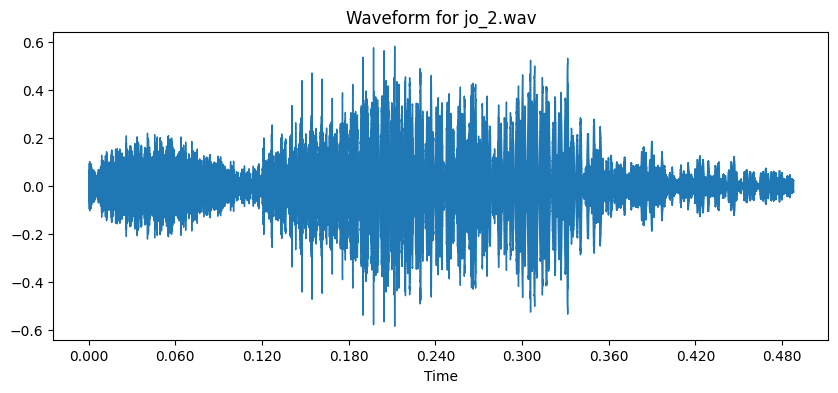

<Figure size 1000x400 with 0 Axes>

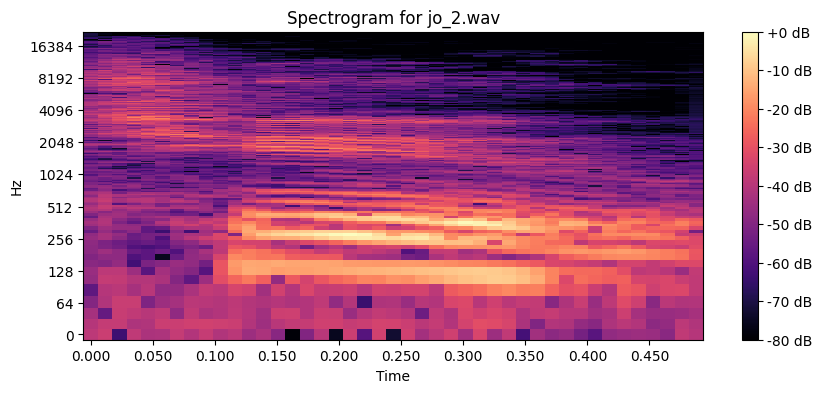

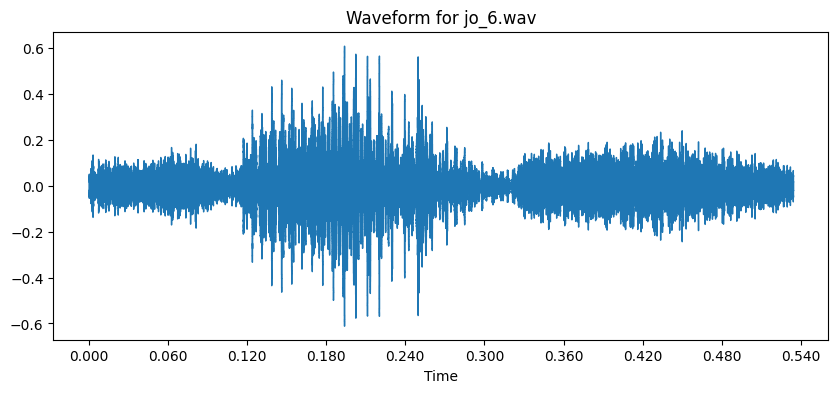

<Figure size 1000x400 with 0 Axes>

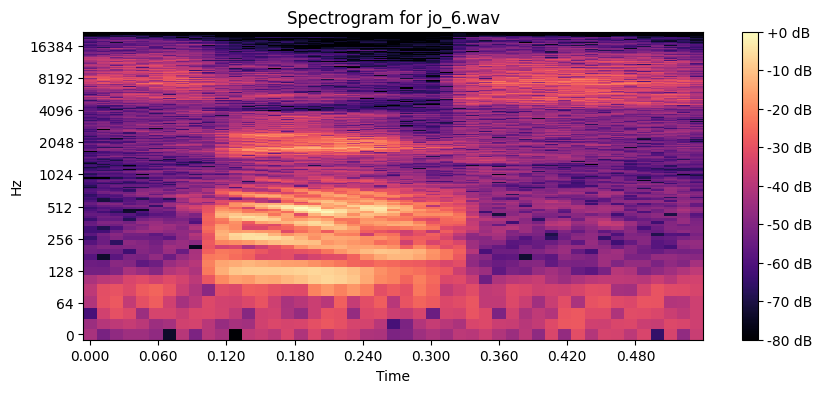

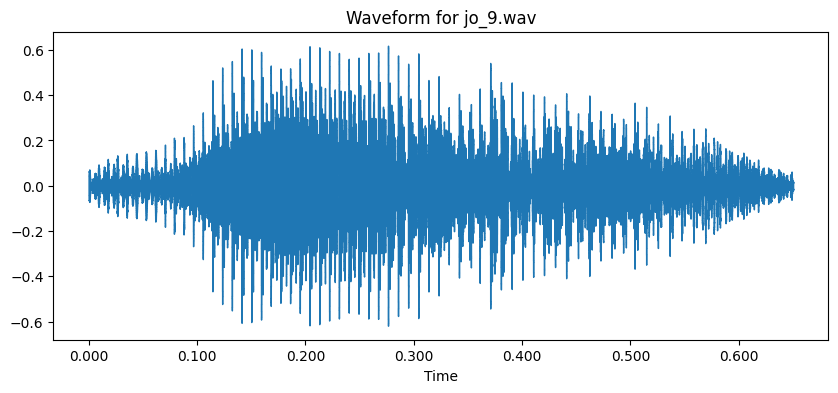

<Figure size 1000x400 with 0 Axes>

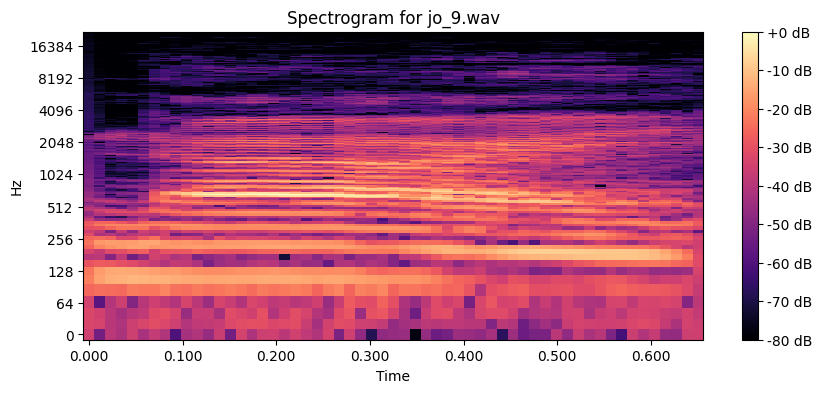

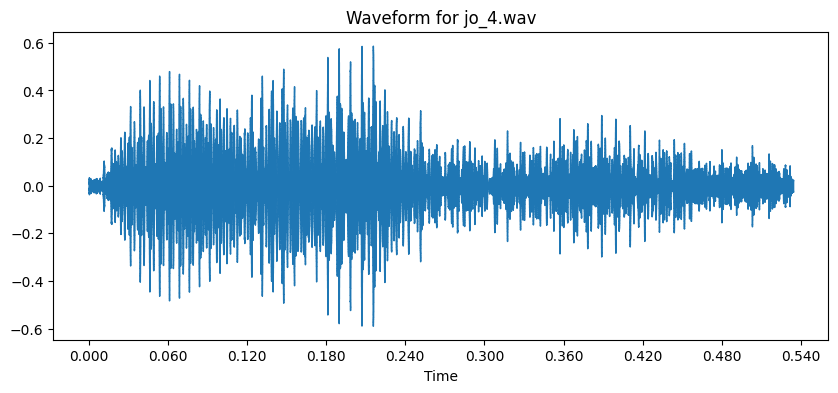

<Figure size 1000x400 with 0 Axes>

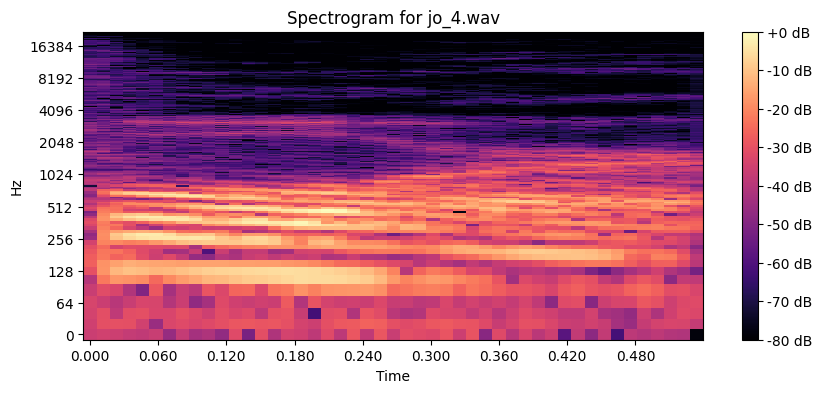

In [5]:
# display spectogramand audio player for all files in jo_digits/unprocessed
import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio, display


# Define the directory for digit 0
digit_dir = 'jo_digits/unprocessed'

# Get all files in the digit directory
files = glob.glob(os.path.join(digit_dir, '*.wav'))

# Display spectogram and audio player for each file
for file in files[:5]:
    # Load the audio file
    y, sr = librosa.load(file, sr=None)
    
    # Display the spectogram
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform for {os.path.basename(file)}')
    plt.show()
    
    # Display the spectogram
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram for {os.path.basename(file)}')
    plt.show()


    display(Audio(file))




In [6]:
# preprocess audio files so that they are all the same length

import glob
import torch as t
import librosa
from torch.utils.data import Dataset, DataLoader
import soundfile as sf
import numpy as np

files = glob.glob('jo_digits/processed/*/*')
print(f"Total files: {len(files)}")

audio_data = []
labels = [] # here is where we create our labels
longest_audio_file_length = 0

# First pass: load data and find longest audio file
for f in tqdm(files):
    try:
        audio, sample_rate = librosa.load(f)
        if len(audio) == 0:
            print(f"Warning: Empty audio file: {f}")
            continue
        labels.append(int(f.split('/')[-2]))  # Adjust this based on your file structure
        longest_audio_file_length = max(longest_audio_file_length, len(audio))
    except Exception as e:
        print(f"Error processing file {f}: {str(e)}")

print(f"Longest audio size: {longest_audio_file_length}")


Total files: 10000


  0%|          | 0/10000 [00:00<?, ?it/s]

Longest audio size: 17920


In [7]:
# Second pass: Pad audio files and resave them
for f in tqdm(files):
    try:
        audio, sample_rate = librosa.load(f)
        if len(audio) == 0:
            print(f"Warning: Empty audio file: {f}")
            continue
        current_size = len(audio)
        pad_size = longest_audio_file_length - current_size
        left_pad = pad_size // 2
        right_pad = pad_size - left_pad
        padded_audio = np.pad(audio, (left_pad, right_pad), mode='constant')
        sf.write(f, padded_audio, sample_rate)
    except Exception as e:
        print(f"Error processing file {f}: {str(e)}")

  0%|          | 0/10000 [00:00<?, ?it/s]

In [8]:
# Third pass: Verify that all files have the same size
file_sizes = []
for f in tqdm(files):
    try:
        audio, _ = librosa.load(f)
        file_sizes.append(len(audio))
    except Exception as e:
        print(f"Error processing file {f}: {str(e)}")

if len(set(file_sizes)) == 1:
    print(f"All files have the same size: {file_sizes[0]} samples")
else:
    print("Warning: Not all files have the same size")
    print(f"Unique file sizes: {set(file_sizes)}")
    print(f"Min size: {min(file_sizes)}, Max size: {max(file_sizes)}")

  0%|          | 0/10000 [00:00<?, ?it/s]

All files have the same size: 17920 samples


In [10]:
print(files[1000:1005])
print(labels[1000:1005])



['jo_digits/processed/2/2_747.wav', 'jo_digits/processed/2/2_691.wav', 'jo_digits/processed/2/2_98.wav', 'jo_digits/processed/2/2_70.wav', 'jo_digits/processed/2/2_500.wav']
[2, 2, 2, 2, 2]


In [21]:
from torchaudio import transforms
import torchaudio
import random

class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, transforms=transforms.MelSpectrogram()):
        self.file_paths = file_paths
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):

        audio_path = self.file_paths[idx]

        waveform, _ = torchaudio.load(audio_path)

        # ensure its mono
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0).unsqueeze(0)

        # apply transforms
        if self.transforms:
            spec = self.transforms(waveform)
        return spec, self.labels[idx]


# Create datasets
full_dataset = AudioDataset(files, labels, transforms=transforms.MelSpectrogram())

train_size = int(0.7 * len(full_dataset))
validation_size = int(0.2 * len(full_dataset))
test_size = int(0.1 * len(full_dataset))

print(train_size)
print(validation_size)
print(test_size)

train_dataset, validation_dataset, test_dataset  = t.utils.data.random_split(full_dataset, [train_size, validation_size, test_size])


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=True)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(validation_loader)}")

7000
2000
1000
Number of training batches: 219
Number of validation batches: 63


In [45]:
import matplotlib.pyplot as plt

# see a batch
for batch in train_loader:
    inputs, targets = batch
    print(inputs.shape)
    print(inputs[0][0].shape)
    print(targets)
    break


mel_freq_bins = inputs[0][0].shape[0]
time_steps = inputs[0][0].shape[1]

print("mel freq bins: ", mel_freq_bins)
print("time steps: ", time_steps)


torch.Size([32, 1, 128, 90])
torch.Size([128, 90])
tensor([1, 0, 0, 7, 4, 0, 5, 7, 7, 0, 5, 6, 9, 0, 0, 8, 8, 5, 0, 8, 3, 0, 6, 3,
        6, 6, 1, 5, 1, 6, 8, 6])
mel freq bins:  128
time steps:  90


In [23]:
# train with a simple MLP

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = t.nn.Sequential(
    t.nn.Flatten(),
    t.nn.Linear(mel_freq_bins*time_steps, 512), # 128 mel bins, 366 time steps
    t.nn.ReLU(),
    t.nn.Linear(512, 512),
    t.nn.ReLU(),
    t.nn.Linear(512, 10),
    t.nn.Softmax(dim=1)
)

# train our model
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

model.to(device)

loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.001)

epochs = 10

print(f"Training for {epochs} epochs")
for epoch in tqdm(range(epochs)):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# evaluate our model

model.eval()

correct = 0
total = 0

with t.no_grad():
    for batch in validation_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        _, predicted = t.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Accuracy of the model on the test set: {100 * correct / total}%")

Using device: cuda
Training for 10 epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/10, Loss: 1.7528176307678223


Epoch 2/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/10, Loss: 1.9611507654190063


Epoch 3/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/10, Loss: 2.168614625930786


Epoch 4/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/10, Loss: 2.1694841384887695


Epoch 5/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/10, Loss: 2.127817392349243


Epoch 6/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 6/10, Loss: 2.211150884628296


Epoch 7/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 7/10, Loss: 2.0444841384887695


Epoch 8/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 8/10, Loss: 2.086150884628296


Epoch 9/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 9/10, Loss: 2.0861494541168213


Epoch 10/10:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 10/10, Loss: 2.377817392349243
Accuracy of the model on the test set: 24.25%


In [24]:
# train with conv net
import torch.nn as nn

device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ConvModel(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the size of the flattened features
        self.flat_features = mel_freq_bins * (mel_freq_bins // 8) * (time_steps // 8)
        
        self.fc1 = nn.Linear(self.flat_features, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # Input shape: (batch_size, 1, 128, 366)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(-1, self.flat_features) # rewrite this line with einops / ARENA
        x = self.relu4(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize the model
conv_model = ConvModel()
print(conv_model)

# Move model to the appropriate device
conv_model = conv_model.to(device)

loss_fn = t.nn.CrossEntropyLoss()
optimizer = t.optim.Adam(conv_model.parameters(), lr=0.001)

epochs = 15

loss_history = []

print(f"Training for {epochs} epochs")
for epoch in tqdm(range(epochs)):
    conv_model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = conv_model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    loss_history.append(avg_loss)

print("finished training")

# plot the loss
plt.plot(loss_history)
plt.show()

# evaluate our model

conv_model.eval()
correct = 0
total = 0

# plot the accuracy
accuracy_history = []

with t.no_grad():
    for batch in validation_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = conv_model(inputs)
        _, predicted = t.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        accuracy_history.append(100 * correct / total)

plt.plot(accuracy_history)
plt.show()

print(f"Accuracy of the conv model on the test set: {100 * correct / total}%")





Using device: cuda
ConvModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=22528, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)
Training for 30 epochs


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 1/30, Loss: 0.017174281179904938


Epoch 2/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 2/30, Loss: 8.415985939791426e-05


Epoch 3/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 3/30, Loss: 0.0077934968285262585


Epoch 4/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 4/30, Loss: 0.0009099606540985405


Epoch 5/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 5/30, Loss: 0.00011646951315924525


Epoch 6/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 6/30, Loss: 0.00023728188534732908


Epoch 7/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 7/30, Loss: 0.005503581836819649


Epoch 8/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 8/30, Loss: 2.7815460157398775e-07


Epoch 9/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 9/30, Loss: 1.3411023758180818e-07


Epoch 10/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 10/30, Loss: 0.0013670561602339149


Epoch 11/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 11/30, Loss: 4.068720227223821e-05


Epoch 12/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 12/30, Loss: 3.3083157177316025e-05


Epoch 13/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 13/30, Loss: 1.9418659576331265e-05


Epoch 14/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 14/30, Loss: 9.818727448873688e-06


Epoch 15/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 15/30, Loss: 0.0


Epoch 16/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 16/30, Loss: 1.3609616189569351e-06


Epoch 17/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 17/30, Loss: 0.0


Epoch 18/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 18/30, Loss: 0.1771463304758072


Epoch 19/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 19/30, Loss: 1.4901160305669237e-08


Epoch 20/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 20/30, Loss: 2.4835260958866456e-08


Epoch 21/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 21/30, Loss: 4.296279712434625e-06


Epoch 22/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 22/30, Loss: 0.0


Epoch 23/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 23/30, Loss: 0.0


Epoch 24/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 24/30, Loss: 0.0


Epoch 25/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 25/30, Loss: 0.0


Epoch 26/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 26/30, Loss: 0.13388292491436005


Epoch 27/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 27/30, Loss: 0.0


Epoch 28/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 28/30, Loss: 0.0


Epoch 29/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 29/30, Loss: 0.0


Epoch 30/30:   0%|          | 0/219 [00:00<?, ?it/s]

Epoch 30/30, Loss: 0.0
Accuracy of the conv model on the test set: 100.0%


In [26]:
# save the model with today's datetime
import datetime
datetime = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#make dir called model_weights
os.makedirs('model_weights', exist_ok=True) 
saved_model_path = f'model_weights/audrey_model_weights_{datetime}.pth'

t.save(conv_model.state_dict(), saved_model_path)

In [96]:
# load the model
print(saved_model_path)
conv_model_loaded = ConvModel()
conv_model_loaded.load_state_dict(t.load(saved_model_path))



model_weights/audrey_model_weights_2024-11-06_15-09-02.pth


/tmp/ipykernel_2332367/611714256.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conv_model_loaded.load_state_dict(t.load(saved_model_path))


<All keys matched successfully>

Test file path: jo_digits/processed/5/5_192.wav
True label: 5


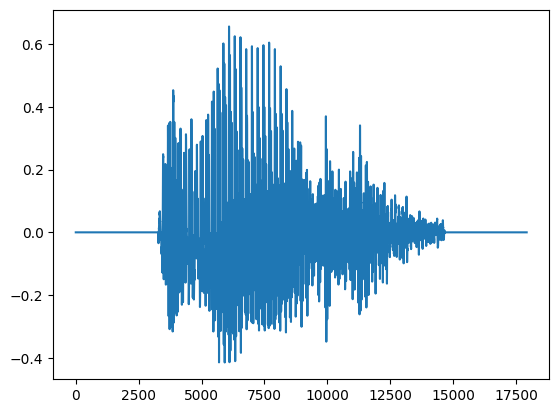

Predicted label: 5


In [100]:
# Get a random test sample
random_idx = random.randint(0, len(test_dataset)-1)

# Get the file path and label
test_file_path = test_dataset.dataset.file_paths[test_dataset.indices[random_idx]]
test_label = test_dataset.dataset.labels[test_dataset.indices[random_idx]]

print(f"Test file path: {test_file_path}")
print(f"True label: {test_label}")

# Load and process the audio
waveform, sample_rate = torchaudio.load(test_file_path)

# display the waveform
plt.plot(waveform.flatten())
plt.show()

# add player
display(Audio(waveform, rate=sample_rate))

mel_spectrogram = transforms.MelSpectrogram()(waveform)
mel_spectrogram = mel_spectrogram.unsqueeze(0)  # Add batch dimension

# Get model prediction
conv_model_loaded.eval()
with t.no_grad():
    output = conv_model_loaded(mel_spectrogram)
    predicted_label = output.argmax().item()

print(f"Predicted label: {predicted_label}")

In [84]:
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]
print("\nTest dataset label distribution:")
print(Counter(test_labels))


Test dataset label distribution:
Counter({8: 111, 2: 106, 5: 105, 4: 105, 9: 103, 1: 101, 0: 98, 3: 92, 7: 90, 6: 89})


In [83]:
# Check label distribution
from collections import Counter
print("Label distribution:")
print(Counter(labels))

# Check a few file paths and their corresponding labels
for i in range(5):
    print(f"\nFile: {files[i]}")
    print(f"Label: {labels[i]}")

Label distribution:
Counter({8: 1000, 2: 1000, 6: 1000, 7: 1000, 5: 1000, 4: 1000, 0: 1000, 9: 1000, 1: 1000, 3: 1000})

File: jo_digits/processed/8/8_982.wav
Label: 8

File: jo_digits/processed/8/8_122.wav
Label: 8

File: jo_digits/processed/8/8_515.wav
Label: 8

File: jo_digits/processed/8/8_556.wav
Label: 8

File: jo_digits/processed/8/8_374.wav
Label: 8
